# Introduction

- Author : Cindra, Izzuddin, Sonny in respect to Mas Danu as our Supervisor


# Step1: Import Library

In [ ]:
import pandas as pd
import numpy as np

import os
import glob
import shutil
from PIL import Image
from torchvision import transforms

import torch
from tqdm import tqdm
from torchvision import models

from numpy.testing import assert_almost_equal
import pickle

# Step 2: Download Our Dataset

We've upload our dataset in Gdrive, you can access the dataset via google drive.
please visit this [link](https://drive.google.com/file/d/17UnxbK4Pg0FEKteulMEpwQEkhvxwHfD0/view?usp=sharing). We recommend you to connect it from your colab (create shortcut first!) rather than downloading and re-uploading it :)

### Step 2.1 : Connect Colab to your Google Drive
You can do it within this code or just connect it from Colab's sidebar

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### Step 2.2 : Copy the dataset to Google Colab
It's not good to load and training all dataset from your Drive. There is a limitation. It'd be better to copy it from your Gdrive to your Colab

In [ ]:
!cp /content/drive/MyDrive/similarity.zip /content/ -r
#path/to/data/in/gdrive               path/to/copy -r

### Step 2.3 : Unzip the dataset

In [ ]:
!unzip '/content//similarity.zip' -d '/content/'

Archive:  /content//similarity.zip
   creating: /content/catalog/
   creating: /content/catalog/blouse/
  inflating: /content/catalog/blouse/blouse_1.jpg  
  inflating: /content/catalog/blouse/blouse_10.jpg  
  inflating: /content/catalog/blouse/blouse_100.jpg  
  inflating: /content/catalog/blouse/blouse_101.jpg  
  inflating: /content/catalog/blouse/blouse_102.jpg  
  inflating: /content/catalog/blouse/blouse_103.jpg  
  inflating: /content/catalog/blouse/blouse_104.jpg  
  inflating: /content/catalog/blouse/blouse_105.jpg  
  inflating: /content/catalog/blouse/blouse_106.jpg  
  inflating: /content/catalog/blouse/blouse_107.jpg  
  inflating: /content/catalog/blouse/blouse_108.jpg  
  inflating: /content/catalog/blouse/blouse_109.jpg  
  inflating: /content/catalog/blouse/blouse_11.jpg  
  inflating: /content/catalog/blouse/blouse_110.jpg  
  inflating: /content/catalog/blouse/blouse_111.jpg  
  inflating: /content/catalog/blouse/blouse_112.jpg  
  inflating: /content/catalog/blouse

# Step 3: Loading Data

In [ ]:
list_catalog = os.listdir('catalog')
list_catalog

['skirts', 'trousers', 'dress', 'blouse', 'cardigan', 'jeans', 'hoodie']

In [ ]:
# needed input dimensions for the CNN
inputDir = "catalog"
inputDirCNN = "inputImagesCNN"

In [ ]:
# create directory for the CNN input
if not os.path.exists(inputDirCNN):
    os.makedirs(inputDirCNN)
    for i in list_catalog:
        os.makedirs(inputDirCNN + '/' + i)

# Step 4: Data Preprocessing

In [ ]:
# needed input dimensions for the CNN
inputDim = (640,640)


# transform to be used for the CNN
transformationForCNNInput = transforms.Compose([
transforms.Resize(inputDim),
])

for i in list_catalog:
    for imageName in os.listdir(inputDir + '/' + i):
        I = Image.open(os.path.join(inputDir + '/' + i, imageName))
        newI = transformationForCNNInput(I)

        # copy the rotation information metadata from original image and save, else your transformed images may be rotated
        # exif = I.info['exif']
        newI.save(os.path.join(inputDirCNN+ '/' + i, imageName))
        newI.close()
        I.close()
  

In [ ]:
# import torch
# from tqdm import tqdm
# from torchvision import models

# for this prototype we use no gpu, cuda= False and as model resnet18 to obtain feature vectors

class Img2VecResnet18():
    def __init__(self):
        
        self.device = torch.device("cuda") # choose "cpu" if you wanna run without GPU
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] --> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer
        

# generate vectors for all the images in the set
img2vec = Img2VecResnet18() 

#create nested dictionary to store the vectors

allVectors = {}

print("Converting images to feature vectors:")
for i in list_catalog:
    allVectors[i] = {}
    for image in tqdm(os.listdir(inputDirCNN + '/' + i)):
        I = Image.open(os.path.join(inputDirCNN + '/' + i, image))
        vec = img2vec.getVec(I)
        allVectors[i][image] = vec
        I.close() 
    # save all the vectors to a pickle file
    with open(f'allVectors_{i}.pkl', 'wb') as f:
        pickle.dump(allVectors[i], f)
    

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Converting images to feature vectors:


100%|██████████| 93/93 [00:01<00:00, 56.82it/s]


In [ ]:
# now let us define a function that calculates the cosine similarity entries in the similarity matrix
import pandas as pd
import numpy as np

def getSimilarityMatrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix


# Step 5: Data Inference

### Insert data inference from folder 'inference'

**Note** the data inference is already the result of object detection, so you must insert the class

In [ ]:
class_inference = 'blouse' # class inference is from object detection
data_inf = Image.open('/content/inference/blouse_1.jpeg')

### Transform the data inference 

In [ ]:
inputDim = (640,640)
def transform(data):
    transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])
    transformationForCNNInput(data)
    return data

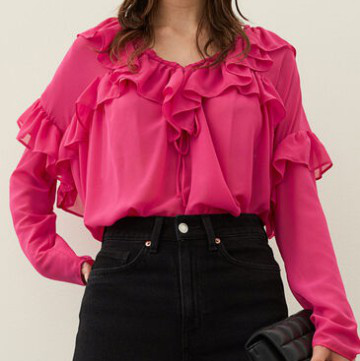

In [ ]:
transform(data_inf)

In [ ]:
data_inf = transformationForCNNInput(data_inf)
data_inf

# save the image to the inputImagesCNN folder
data_inf.save('/content/inference/data_inf.jpeg')

#### Load vector based on the class inference

In [ ]:
# load the vectors from the pickle file
with open(f"allVectors_{class_inference}.pkl", "rb") as f:
    allVectors_test = pickle.load(f)


In [ ]:
allVectors_test['data_inf.jpeg'] = img2vec.getVec(data_inf)

In [ ]:
similarityMatrix = getSimilarityMatrix(allVectors_test)
similarityMatrix

,blouse_21.jpg,blouse_117.jpg,blouse_114.jpg,blouse_120.jpg,blouse_45.jpg,blouse_68.jpg,blouse_15.jpg,blouse_8.jpg,blouse_40.jpg,blouse_61.jpg,...,blouse_37.jpg,blouse_3.jpg,blouse_60.jpg,blouse_39.jpg,blouse_63.jpg,blouse_19.jpg,blouse_98.jpg,blouse_79.jpg,blouse_53.jpg,data_inf.jpeg
blouse_21.jpg,1.000000,0.907363,0.793178,0.878859,0.884472,0.922563,0.946931,0.955656,0.917984,0.839060,...,0.918544,0.809893,0.871470,0.908455,0.877636,0.956584,0.904418,0.899617,0.915777,0.788001
blouse_117.jpg,0.907363,1.000000,0.774343,0.810030,0.886274,0.901265,0.932428,0.882774,0.891520,0.790957,...,0.911458,0.796260,0.859930,0.940608,0.861598,0.873131,0.826175,0.782319,0.924969,0.712589
blouse_114.jpg,0.793178,0.774343,1.000000,0.723780,0.763693,0.802005,0.801584,0.792148,0.786725,0.767770,...,0.767758,0.866373,0.843127,0.759208,0.799800,0.795875,0.768209,0.748526,0.781633,0.751233
blouse_120.jpg,0.878859,0.810030,0.723780,1.000000,0.892797,0.841380,0.808175,0.889050,0.866819,0.908467,...,0.819982,0.779544,0.833691,0.806889,0.877719,0.889447,0.946233,0.894325,0.855474,0.853481
blouse_45.jpg,0.884472,0.886274,0.763693,0.892797,0.999999,0.882333,0.859790,0.907156,0.898755,0.926233,...,0.870807,0.807419,0.875251,0.880862,0.922041,0.901284,0.883663,0.873960,0.896352,0.828702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
blouse_19.jpg,0.956584,0.873131,0.795875,0.889447,0.901284,0.926310,0.921335,0.951646,0.925150,0.895456,...,0.878006,0.818850,0.897232,0.883669,0.909376,1.000000,0.903384,0.918129,0.917871,0.841921
blouse_98.jpg,0.904418,0.826175,0.768209,0.946233,0.883663,0.872432,0.837274,0.900095,0.864535,0.875667,...,0.829427,0.764412,0.841700,0.816568,0.865596,0.903384,1.000000,0.897369,0.854845,0.859987
blouse_79.jpg,0.899617,0.782319,0.748526,0.894325,0.873960,0.847816,0.823461,0.896054,0.852497,0.868404,...,0.862968,0.791032,0.841123,0.827083,0.857236,0.918129,0.897369,1.000000,0.856584,0.868037
blouse_53.jpg,0.915777,0.924969,0.781633,0.855474,0.896352,0.926058,0.917280,0.924105,0.892324,0.830528,...,0.923551,0.813037,0.896884,0.916966,0.890789,0.917871,0.854845,0.856584,1.000000,0.754429


In [ ]:
similarityMatrix.loc['data_inf.jpeg'].sort_values(ascending = False).head(5)

data_inf.jpeg     1.000000
blouse_61.jpg     0.884760
blouse_22.jpg     0.876967
blouse_106.jpg    0.873242
blouse_57.jpg     0.868458
Name: data_inf.jpeg, dtype: float32

In [ ]:
from numpy.testing import assert_almost_equal
import pickle

k = 5 # the number of top similar images to be stored

similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))

for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values
    
similarNames.to_pickle("similarNames.pkl")
similarValues.to_pickle("similarValues.pkl")

100%|██████████| 121/121 [00:00<00:00, 2186.55it/s]


### Plot the inference

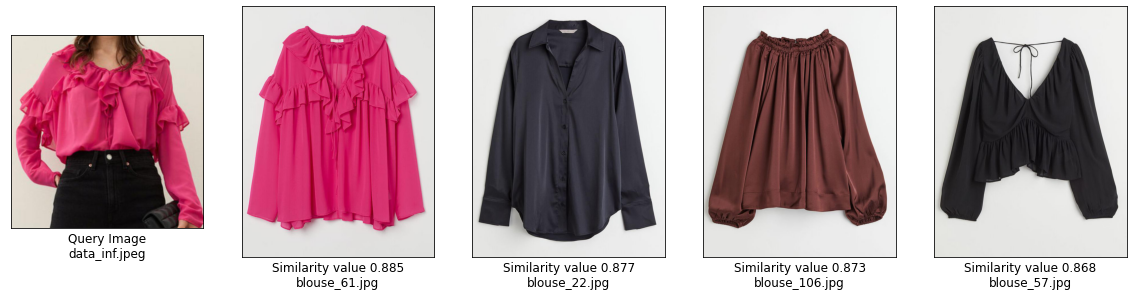

In [ ]:
import matplotlib.pyplot as plt
    
# take three examples from the provided image set and plot
inputImages = ["data_inf.jpeg"]

numCol = 5
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 12)
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format( image,  value), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    
def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal = 5)
            imgs.remove(image)
            vals.remove(max(vals))
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))
        
def plotSimilarImages(image, similarNames, similarValues):
    simImages, simValues = getSimilarImages(image, similarNames, similarValues)
    fig = plt.figure(figsize=(20, 40))
    
    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0:
            img = Image.open(os.path.join('inference', image))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else:
            img = Image.open(os.path.join(inputDir + '/' + class_inference, simImages[j-1]))
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], simImages[j-1], value = simValues[j-1])
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    
    plt.show()
        
for image in inputImages:
    plotSimilarImages(image, similarNames, similarValues)